In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
x_train_images = np.load("data/x_train_images.npy")
x_test_images = np.load("data/x_test_images.npy")
  
x_train_images_100 = np.load("data/x_train_images_100.npy")
x_test_images_100 = np.load("data/x_test_images_100.npy")

x_train_images_50 = np.load("data/x_train_images_50.npy")
x_test_images_50 = np.load("data/x_test_images_50.npy")

x_train_nhts = np.load("data/x_train_nhts.npy")
x_test_nhts = np.load("data/x_test_nhts.npy")

y_train = np.load("data/y_train.npy")
y_test = np.load("data/y_test.npy")
print("The sample size of training set is: ", x_train_images.shape[0])
print("The sample size of testing set is: ", x_test_images.shape[0])

print(y_train.shape)
print(y_test.shape)

The sample size of training set is:  3556
The sample size of testing set is:  889
(3556, 1)
(889, 1)


In [4]:
# bridge numpy to torch
x_train_images_torch = torch.as_tensor(x_train_images).float()
x_test_images_torch = torch.as_tensor(x_test_images).float()

x_train_images_torch_100 = torch.as_tensor(x_train_images_100).float()
x_test_images_torch_100 = torch.as_tensor(x_test_images_100).float()

x_train_images_torch_50 = torch.as_tensor(x_train_images_50).float()
x_test_images_torch_50 = torch.as_tensor(x_test_images_50).float()

x_train_nhts_torch = torch.as_tensor(x_train_nhts).float() # specify floats for the inputs
x_test_nhts_torch = torch.as_tensor(x_test_nhts).float()

y_train_torch = torch.as_tensor(y_train[:,0])
y_test_torch = torch.as_tensor(y_test[:,0])
n_train = x_train_images.shape[0]
n_test = x_test_images.shape[0]
# inputs: x_train_nhts, x_train_images, x_test_nhts, x_test_images, y_train, and y_test; 
K = len(np.unique(y_train))
x_dim = x_train_nhts.shape[1]
# 
pd.value_counts(y_train[:,0])/y_train.shape[0]

2    0.336333
1    0.325928
3    0.251969
0    0.085771
dtype: float64

In [5]:
##### Type 2: CNN with images.
# To-Do: Use GPU...
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # To-Do: need to have more channels for higher accuracy. 
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=8, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=4)
        # Question: Why is this 48*48 correct? bc 97//2 = 48
        self.fc11 = nn.Linear(in_features=4 * 45 * 45, out_features=64)
        self.fc12 = nn.Linear(in_features=64, out_features=128)
        
        self.fc21 = nn.Linear(in_features=4 * 20 * 20, out_features=64)
        self.fc22 = nn.Linear(in_features=64, out_features=128)
        
        self.fc31 = nn.Linear(in_features=4 * 8 * 8, out_features=64)
        self.fc32 = nn.Linear(in_features=64, out_features=128)
        
        self.fcNN1 = nn.Linear(x_dim, 100)        
        self.fcNN2 = nn.Linear(100, 100)
        self.fcNN3 = nn.Linear(100, 100)
        
        self.fcFinal = nn.Linear(in_features=128*3 + 100, out_features=K)
        self.relu = F.relu
        self.pool = F.max_pool2d
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x1, x2, x3,nhts):
        out = self.relu(self.conv1(x1))
        out = self.pool(out, 2)
        out = self.relu(self.conv2(out))
        out = self.pool(out, 2)
        out = self.relu(self.conv3(out))
        #print(out.shape,"out1")
        out = out.reshape(out.size(0), -1)
        out = self.relu(self.fc11(out))
        out = self.fc12(out)
        
        out2 = self.relu(self.conv1(x2))
        out2 = self.pool(out2, 2)
        out2 = self.relu(self.conv2(out2))
        out2 = self.pool(out2, 2)
        out2 = self.relu(self.conv3(out2))
        #print(out2.shape,"out2")
        out2 = out2.reshape(out2.size(0), -1)
        out2 = self.relu(self.fc21(out2))
        out2 = self.fc22(out2)
        
        
        out3 = self.relu(self.conv1(x3))
        out3 = self.pool(out3, 2)
        out3 = self.relu(self.conv2(out3))
        out3 = self.pool(out3, 2)
        out3 = self.relu(self.conv3(out3))
        #print(out3.shape,"out3")
        out3 = out3.reshape(out3.size(0), -1)
        out3 = self.relu(self.fc31(out3))
        out3 = self.fc32(out3)
        
        nhts = self.fcNN1(nhts)
        nhts = nhts.relu()
        nhts = self.fcNN2(nhts)
        nhts = nhts.relu()
        nhts = self.fcNN3(nhts)
        
        
        #print(torch.cat((torch.cat((torch.cat((out,out2),1),out3),1),nhts),1).shape)
        final_out = self.fcFinal(torch.cat((torch.cat((torch.cat((out,out2),1),out3),1),nhts),1))
        #print("hello")
        final_out = self.softmax(final_out)
        return final_out

In [6]:
# normalize the data
x_train_images_norm_torch = x_train_images_torch/255.0
x_test_images_norm_torch = x_test_images_torch/255.0

x_train_images_norm_torch_100 = x_train_images_torch_100/255.0
x_test_images_norm_torch_100 = x_test_images_torch_100/255.0

x_train_images_norm_torch_50 = x_train_images_torch_50/255.0
x_test_images_norm_torch_50 = x_test_images_torch_50/255.0
# 
cnn_net = CNN().float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 150 # To-Do: need more epoches.
batch_size = 200 

In [7]:
# training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for n_epoch in range(n_epoches):
    # create permutation for batch training
    # To-Do: add permutation for SGD...But it is slow.
#    permutation = torch.randperm(x_train_images_norm_torch.size()[0])
    for i in range(0, x_train_images_norm_torch.size()[0], batch_size):
        print(n_epoch, i)
        # clear gradients first (for each iteration!)!
        optim.zero_grad()
        # forward pass
        batch_x, batch_y = x_train_images_norm_torch[i:i+batch_size, :, :, :].to(device), y_train_torch[i:i+batch_size].to(device)
        
        batch_x_100 = x_train_images_norm_torch_100[i:i+batch_size, :, :, :].to(device)
        batch_x_50 = x_train_images_norm_torch_50[i:i+batch_size, :, :, :].to(device)
        
        batch_x_nhts = x_train_nhts_torch[i:i+batch_size].to(device)
        
        batch_y_pred_train = cnn_net(batch_x,batch_x_100,batch_x_50, batch_x_nhts)
        # loss 
        loss = criterion(batch_y_pred_train.squeeze(), batch_y)
        # compute gradients
        loss.backward()
        # one step optim
        optim.step()

    # eval training accuracy
    with torch.no_grad():
        y_pred_train = cnn_net(x_train_images_norm_torch.to(device),x_train_images_norm_torch_100.to(device),x_train_images_norm_torch_50.to(device),x_train_nhts_torch.to(device))
        loss_train = criterion(y_pred_train.squeeze(), y_train_torch.to(device))
        train_losses.append(loss_train)
        
        _, predict_train = torch.max(y_pred_train, axis = 1)
        accuracy_train = (predict_train == y_train_torch.to(device)).sum().item()/n_train  
        train_accuracies.append(accuracy_train)
        # evaluate testing sets step-wise
        cnn_net.eval()
        y_pred_test = cnn_net(x_test_images_norm_torch.to(device),x_test_images_norm_torch_100.to(device),x_test_images_norm_torch_50.to(device),x_test_nhts_torch.to(device))
       
        loss_test = criterion(y_pred_test.squeeze().to(device), y_test_torch.to(device))
        test_losses.append(loss_test)
        _, predict_test = torch.max(y_pred_test.to(device), axis = 1)
        accuracy_test = (predict_test == y_test_torch.to(device)).sum().item()/n_test
        test_accuracies.append(accuracy_test)
        # print info
        if n_epoch % 1 == 0:
            print('Epoch {}: train loss: {}; test loss: {}'.format(n_epoch, loss.item(), loss_test.item()))
            print('Epoch {}: train accuracy: {}; test accuracy: {}'.format(n_epoch, accuracy_train, accuracy_test))


# notes:
# CPU training: about 30 mins, with SIMPLEST CNN architecture, 20 epoches and 200 batch_size. 
# training accuracy: 60%; testing accuracy: 60%.  

0 0
0 200
0 400
0 600
0 800
0 1000
0 1200
0 1400
0 1600
0 1800
0 2000
0 2200
0 2400
0 2600
0 2800
0 3000
0 3200
0 3400
Epoch 0: train loss: 1.2819266319274902; test loss: 1.2410588264465332
Epoch 0: train accuracy: 0.4777840269966254; test accuracy: 0.4814398200224972
1 0
1 200
1 400
1 600
1 800
1 1000
1 1200
1 1400
1 1600
1 1800
1 2000
1 2200
1 2400
1 2600
1 2800
1 3000
1 3200
1 3400
Epoch 1: train loss: 1.2516868114471436; test loss: 1.2556449174880981
Epoch 1: train accuracy: 0.4583802024746907; test accuracy: 0.4645669291338583
2 0
2 200
2 400
2 600
2 800
2 1000
2 1200
2 1400
2 1600
2 1800
2 2000
2 2200
2 2400
2 2600
2 2800
2 3000
2 3200
2 3400
Epoch 2: train loss: 1.2439155578613281; test loss: 1.2313867807388306
Epoch 2: train accuracy: 0.5044994375703037; test accuracy: 0.4938132733408324
3 0
3 200
3 400
3 600
3 800
3 1000
3 1200
3 1400
3 1600
3 1800
3 2000
3 2200
3 2400
3 2600
3 2800
3 3000
3 3200
3 3400
Epoch 3: train loss: 1.2036211490631104; test loss: 1.2169476747512817
Epo

29 1200
29 1400
29 1600
29 1800
29 2000
29 2200
29 2400
29 2600
29 2800
29 3000
29 3200
29 3400
Epoch 29: train loss: 0.9326841831207275; test loss: 0.9852153658866882
Epoch 29: train accuracy: 0.7952755905511811; test accuracy: 0.7581552305961755
30 0
30 200
30 400
30 600
30 800
30 1000
30 1200
30 1400
30 1600
30 1800
30 2000
30 2200
30 2400
30 2600
30 2800
30 3000
30 3200
30 3400
Epoch 30: train loss: 0.9379668831825256; test loss: 0.9945069551467896
Epoch 30: train accuracy: 0.7859955005624297; test accuracy: 0.7457817772778402
31 0
31 200
31 400
31 600
31 800
31 1000
31 1200
31 1400
31 1600
31 1800
31 2000
31 2200
31 2400
31 2600
31 2800
31 3000
31 3200
31 3400
Epoch 31: train loss: 0.9327122569084167; test loss: 0.9846988320350647
Epoch 31: train accuracy: 0.7924634420697413; test accuracy: 0.7536557930258717
32 0
32 200
32 400
32 600
32 800
32 1000
32 1200
32 1400
32 1600
32 1800
32 2000
32 2200
32 2400
32 2600
32 2800
32 3000
32 3200
32 3400
Epoch 32: train loss: 0.9342256188392

58 600
58 800
58 1000
58 1200
58 1400
58 1600
58 1800
58 2000
58 2200
58 2400
58 2600
58 2800
58 3000
58 3200
58 3400
Epoch 58: train loss: 0.9121820330619812; test loss: 0.9565118551254272
Epoch 58: train accuracy: 0.8160854893138357; test accuracy: 0.7862767154105736
59 0
59 200
59 400
59 600
59 800
59 1000
59 1200
59 1400
59 1600
59 1800
59 2000
59 2200
59 2400
59 2600
59 2800
59 3000
59 3200
59 3400
Epoch 59: train loss: 0.9111667275428772; test loss: 0.9547443389892578
Epoch 59: train accuracy: 0.8174915635545557; test accuracy: 0.7874015748031497
60 0
60 200
60 400
60 600
60 800
60 1000
60 1200
60 1400
60 1600
60 1800
60 2000
60 2200
60 2400
60 2600
60 2800
60 3000
60 3200
60 3400
Epoch 60: train loss: 0.916497528553009; test loss: 0.9566145539283752
Epoch 60: train accuracy: 0.8141169853768279; test accuracy: 0.7874015748031497
61 0
61 200
61 400
61 600
61 800
61 1000
61 1200
61 1400
61 1600
61 1800
61 2000
61 2200
61 2400
61 2600
61 2800
61 3000
61 3200
61 3400
Epoch 61: train 

Epoch 86: train loss: 0.9097766280174255; test loss: 0.9578835964202881
Epoch 86: train accuracy: 0.8177727784026997; test accuracy: 0.7840269966254219
87 0
87 200
87 400
87 600
87 800
87 1000
87 1200
87 1400
87 1600
87 1800
87 2000
87 2200
87 2400
87 2600
87 2800
87 3000
87 3200
87 3400
Epoch 87: train loss: 0.9112098813056946; test loss: 0.9567640423774719
Epoch 87: train accuracy: 0.8177727784026997; test accuracy: 0.7885264341957255
88 0
88 200
88 400
88 600
88 800
88 1000
88 1200
88 1400
88 1600
88 1800
88 2000
88 2200
88 2400
88 2600
88 2800
88 3000
88 3200
88 3400
Epoch 88: train loss: 0.9105468988418579; test loss: 0.9556123614311218
Epoch 88: train accuracy: 0.8194600674915635; test accuracy: 0.7885264341957255
89 0
89 200
89 400
89 600
89 800
89 1000
89 1200
89 1400
89 1600
89 1800
89 2000
89 2200
89 2400
89 2600
89 2800
89 3000
89 3200
89 3400
Epoch 89: train loss: 0.910682201385498; test loss: 0.9551214575767517
Epoch 89: train accuracy: 0.8177727784026997; test accuracy: 0

114 600
114 800
114 1000
114 1200
114 1400
114 1600
114 1800
114 2000
114 2200
114 2400
114 2600
114 2800
114 3000
114 3200
114 3400
Epoch 114: train loss: 0.9158676266670227; test loss: 0.9553395509719849
Epoch 114: train accuracy: 0.8177727784026997; test accuracy: 0.7874015748031497
115 0
115 200
115 400
115 600
115 800
115 1000
115 1200
115 1400
115 1600
115 1800
115 2000
115 2200
115 2400
115 2600
115 2800
115 3000
115 3200
115 3400
Epoch 115: train loss: 0.9190943837165833; test loss: 0.9654680490493774
Epoch 115: train accuracy: 0.8143982002249719; test accuracy: 0.7716535433070866
116 0
116 200
116 400
116 600
116 800
116 1000
116 1200
116 1400
116 1600
116 1800
116 2000
116 2200
116 2400
116 2600
116 2800
116 3000
116 3200
116 3400
Epoch 116: train loss: 0.9112778902053833; test loss: 0.9569483995437622
Epoch 116: train accuracy: 0.8188976377952756; test accuracy: 0.7862767154105736
117 0
117 200
117 400
117 600
117 800
117 1000
117 1200
117 1400
117 1600
117 1800
117 2000
117

141 600
141 800
141 1000
141 1200
141 1400
141 1600
141 1800
141 2000
141 2200
141 2400
141 2600
141 2800
141 3000
141 3200
141 3400
Epoch 141: train loss: 0.9100573658943176; test loss: 0.9516259431838989
Epoch 141: train accuracy: 0.8250843644544432; test accuracy: 0.7919010123734533
142 0
142 200
142 400
142 600
142 800
142 1000
142 1200
142 1400
142 1600
142 1800
142 2000
142 2200
142 2400
142 2600
142 2800
142 3000
142 3200
142 3400
Epoch 142: train loss: 0.9100784063339233; test loss: 0.9526498317718506
Epoch 142: train accuracy: 0.8248031496062992; test accuracy: 0.7896512935883014
143 0
143 200
143 400
143 600
143 800
143 1000
143 1200
143 1400
143 1600
143 1800
143 2000
143 2200
143 2400
143 2600
143 2800
143 3000
143 3200
143 3400
Epoch 143: train loss: 0.910028338432312; test loss: 0.9531381726264954
Epoch 143: train accuracy: 0.8250843644544432; test accuracy: 0.7896512935883014
144 0
144 200
144 400
144 600
144 800
144 1000
144 1200
144 1400
144 1600
144 1800
144 2000
144 

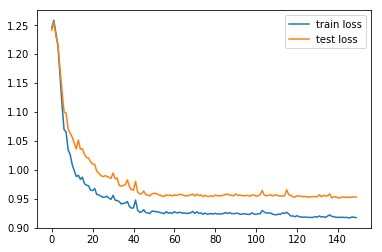

In [8]:
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()

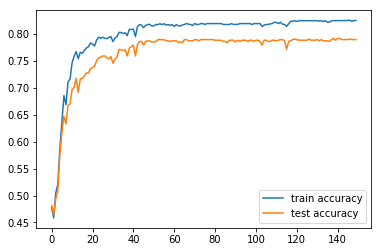

In [9]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(test_accuracies, label = "test accuracy")
plt.legend()

In [11]:
torch.save(cnn_net.state_dict(), "data/cnn_gaussian_6layer")